# **Wikiwomen: An analysis on gender bias**
*metADAta*

We begin with taking a look at the Wikispeedia dataset and importing the files from it. The dataframe `female` is an additional dataset that we constructed ourselves.

### **Dataframes: Columns and descriptions**

| Name of dataframe | Columns                                                         | Description                                                                   |   |   |
|-------------------|-----------------------------------------------------------------|-------------------------------------------------------------------------------|---|---|
| articles          | [article]                                                       | Contains the name of a wikispeedia article                                    |   |   |
| categories        | [article, category]                                             | Contains the name of a wikispeedia article and its corresponding category     |   |   |
| links             | [link_source, link_target]                                      | Contains the source and target article between paths that were tested         |   |   |
| paths_finished    | [hashedIpAddress, timestamp, durationInSec, path, rating]       | Contains all finished paths                                                   |   |   |
| paths_unfinished  | [hashedIpAddress, timestamp, durationInSec, path, target, type] | Contains all unfinished paths. Type refers to the reason they were unfinished |   |   |
| female  | [women, womenLabel] | Contains a list of articles about females and their corresponding subcategory |   |   |

### **Importing the data**

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
FEMALES = DATA_FOLDER + "listwomen.txt"

In [152]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

#### **Dataframes: Basic statistics**

##### **Articles**

In [4]:
print(f"Number of articles in the dataset: {len(articles)}")
articles.head(10)

Number of articles in the dataset: 4604


,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts
5,%E2%82%AC2_commemorative_coins
6,10th_century
7,11th_century
8,12th_century
9,13th_century


##### **Categories**

In [19]:
print(f"Number of rows in the dataset: {len(categories)}")
categories.head()

Number of rows in the dataset: 5204


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [46]:
# Number of articles in each category
n_artcat = categories.groupby(categories["category"]).nunique()

print(f"The number of categories are {len(n_artcat)}")
n_artcat

The number of categories are 129


,article
category,
subject.Art.Art,36
subject.Art.Artists,2
subject.Business_Studies.Business,28
subject.Business_Studies.Companies,18
subject.Business_Studies.Currency,14
...,...
subject.Science.Physics.Electricity_and_Electronics,20
subject.Science.Physics.General_Physics,55
subject.Science.Physics.Space_Astronomy,105


##### **Links**

In [23]:
print(f"Number of combinations of source and target articles in the dataset: {len(links)}")
links.head(5)

Number of combinations of source and target articles in the dataset: 119882


,link_source,link_target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


##### **Finished paths**

In [20]:
print(f"Number of finished paths: {len(paths_finished)}")
paths_finished.head(5)

Number of finished paths: 51318


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


##### **Unfinished paths**

In [21]:
print(f"Number of unfinished paths: {len(paths_unfinished)}")
paths_unfinished.head(5)

Number of unfinished paths: 24875


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


##### **Females**

In [133]:
print(f"Number of articles about women: {len(female)}")
female.head()

Number of articles about women: 58


,name,women_label
0,Bette_Davis,subject.People.Actors_models_and_celebrities
1,Britney_Spears,subject.People.Actors_models_and_celebrities
2,Diane_Keaton,subject.People.Actors_models_and_celebrities
3,Emma_Roberts,subject.People.Actors_models_and_celebrities
4,Evan_Rachel_Wood,subject.People.Actors_models_and_celebrities


### **Pre-proccessing and visualizations**

Building the dataframe we are going to use:

In [117]:
# finding the articles that are within the People category
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))

# constructing a new dataframe called people, only with articles from the people category
people = categories[categories["category_people"] == True]

# splitting the categories into main- and subcategories
people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns=["category_people", "category", 0, 1])
people = people.rename(columns={"article": "name", 2:"category",})

# drop duplicates 
people = people.drop_duplicates(subset=['name'])     

The number of articles about people are 676


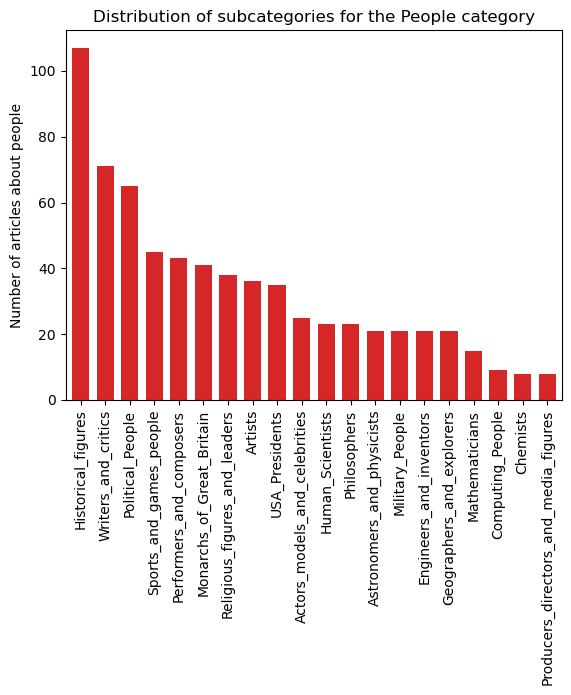

In [130]:
print(f"The number of articles about people are {len(people)}")

# plotting the distribution of subcategories within the People category
subcategories_dist = people["category"].value_counts()
subcategories_dist.plot.bar(title = "Distribution of subcategories for the People category",
                            ylabel = 'Number of articles about people', 
                            color = "tab:red", width = 0.7)
plt.show()

In [141]:
# identify women and men in the dataframe
people["gender"] =  people['name'].isin(female["name"])
people["gender"] = people["gender"].apply(lambda x: "female" if x else "male")

# counting in- and out-links
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()

# drop all people that have no in_link - impossible to reach the article
people = people.merge(count_links_src, how = "left", left_on = "name", right_index = True)
people = people.merge(count_links_target, how = "inner", left_on = "name", right_index=True)
people = people.rename(columns = {"link_source": "nr_link_out", "link_target": "nr_link_in"})

In [145]:
people.head()

,name,category,gender,nr_link_out,nr_link_in
95,Abel_Tasman,Geographers_and_explorers,male,14,5
105,Abraham_Lincoln,USA_Presidents,male,35,62
129,Adam_Smith,Historical_figures,male,27,38
134,Adolf_Hitler,Political_People,male,78,109
159,Agamemnon,Historical_figures,male,11,9


In [146]:
def process_path(path):
    '''
    Decompose a path and find its length. 
    Assumption: When back-clicks are encountered, we increase the path length by 1
    :param path: a full-length path
    :return: source, target, length
    '''
    p = path.split(";")
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length

In [161]:
# expand the finished paths 
path_fin = paths_finished.copy()
path_fin["source"], path_fin["target"], path_fin["human_length"] =  zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_fin["finished"] = True
path_fin

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin["source"], path_ufin["failure_article"], path_ufin["human_length"] =  zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_ufin["finished"] = False
path_ufin['target'] = paths_unfinished["target"]

path_overview = pd.concat([path_fin, path_ufin])
path_overview = path_overview[["source", "target", "finished", "human_length", "finished", "durationInSec", "type", "failure_article"]]

In [162]:
path_overview

,source,target,finished,human_length,finished,durationInSec,type,failure_article
0,14th_century,African_slave_trade,True,9,True,166,NaN,NaN
1,14th_century,African_slave_trade,True,5,True,88,NaN,NaN
2,14th_century,African_slave_trade,True,8,True,138,NaN,NaN
3,14th_century,Greece,True,4,True,37,NaN,NaN
4,14th_century,John_F._Kennedy,True,7,True,175,NaN,NaN
...,...,...,...,...,...,...,...,...
24870,Franz_Kafka,Cholera,False,8,False,180,restart,Ghana
24871,Modern_history,Hollandic,False,1,False,6,restart,Modern_history
24872,Computer_programming,The_Beatles,False,5,False,1900,timeout,<
24873,Jamaica,Alan_Turing,False,4,False,1903,timeout,Battle_of_Midway


### **Initial visulizations**

We begin with constructing a new dataframe `people` that contains all articles in the category of People (refers to "subject.People") and their corresponding subcategory.

We will now create two new dataframes, called `finpaths_women_target` and `finpaths_men_target`, that contain respectively all finished paths that have a women and men as a target article. We begin with constructing a pandas series `womenName` of all articles about women using the handmade `female` dataframe. Using the newly constructed `people` dataframe, we can construct a series of articles about men by filtering out every article about women from `people`. If the target article in a finished path is in any of the two women and men lists, we can construct the desired dataframe.

In [67]:
womenName = female['women']                                      # A series of all articles about women
menName = people[~people['article'].isin(womenName)]['article']  # A series of all articles about men

# Add the columns source and target to paths_finished
paths_finished['source'] = paths_finished['path'].str.split(';').str[0]
paths_finished['target'] = paths_finished['path'].str.split(';').str[-1]

# if target is in womenName, add row to dataframe
finpaths_women_target = paths_finished[paths_finished['target'].isin(womenName)]

# if target is in menName, add row to dataframe
finpaths_men_target = paths_finished[paths_finished['target'].isin(menName)]

##### Finished paths with women and men target articles

In [68]:
print(f"Number of articles that have women as a target is {len(finpaths_women_target)}")
print(f"Number of articles that have men as a target is {len(finpaths_men_target)}")

Number of articles that have women as a target is 347
Number of articles that have men as a target is 5566


##### Unfinished paths with women and men target articles

In [69]:
# Add the column source to paths_unfinished
paths_unfinished['source'] = paths_unfinished['path'].str.split(';').str[0]

# if target is in womenName, add row to dataframe
unfinpaths_women_target = paths_unfinished[paths_unfinished['target'].isin(womenName)]

# if target is in menName, add row to dataframe
unfinpaths_men_target = paths_unfinished[paths_unfinished['target'].isin(menName)]

In [70]:
print(f"Number of unfinished paths that have women as a target {len(unfinpaths_women_target)}")
print(f"Number of unfinished paths that have men as a target {len(unfinpaths_men_target)}")

Number of unfinished paths that have women as a target 342
Number of unfinished paths that have men as a target 2374


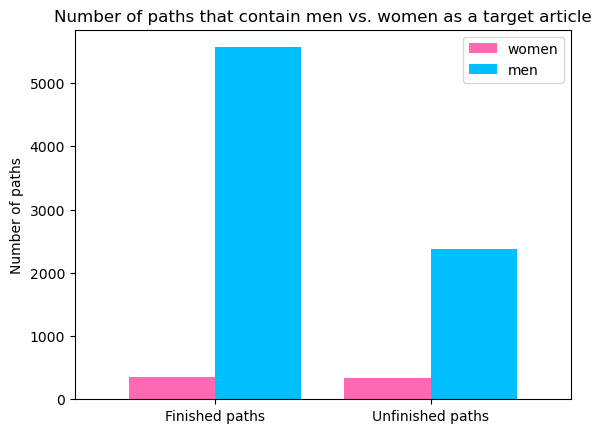

In [71]:
women = [len(finpaths_women_target), len(unfinpaths_women_target)]
men = [len(finpaths_men_target), len(unfinpaths_men_target)]
index = ['Finished paths', 'Unfinished paths']
compare_mv = pd.DataFrame({'women': women,'men': men}, index=index)
ax = compare_mv.plot.bar(rot=0, color = ['hotpink','deepskyblue'], 
                         title = "Number of paths that contain men vs. women as a target article",
                         ylabel = 'Number of paths', width = 0.8)

In [72]:
split = categories['category'].str.split(".", expand=True)
categories = pd.concat([categories["article"], split], axis=1)

# Check if all values in 0 are subject, then discard column 
if (categories[0] == categories[0][0]).all():
    categories = categories.drop(columns=0)

categories.columns = ["Name", "Subject", "SubCat1", "SubCat2"]
categories.head(5)

,Name,Subject,SubCat1,SubCat2
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,History,British_History,British_History_1500_and_before_including_Roma...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,Historical_figures,None
2,%C3%85land,Countries,None,None
3,%C3%85land,Geography,European_Geography,European_Countries
4,%C3%89douard_Manet,People,Artists,None


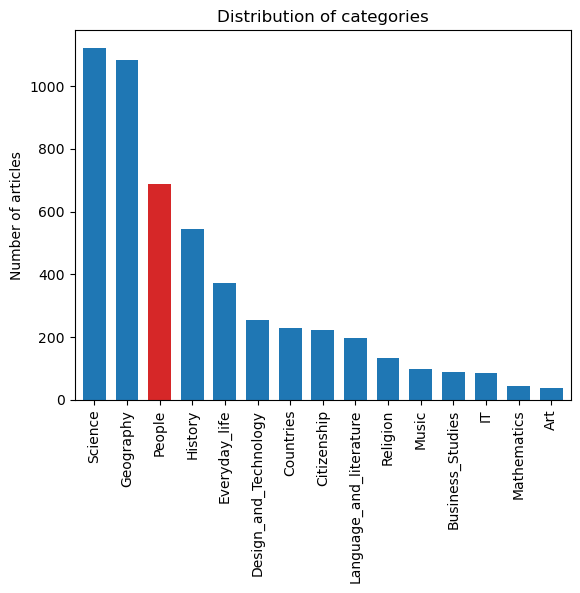

In [73]:
topic_dist = categories['Subject'].value_counts()
topic_dist.plot.bar(title = "Distribution of categories", 
                    color=['tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue',
                           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
                          'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue'],
                    ylabel = 'Number of articles', width = 0.7)
plt.show()

In [75]:
womenPeople = people[people['article'].isin(womenName)]
menPeople = people[people['article'].isin(menName)]

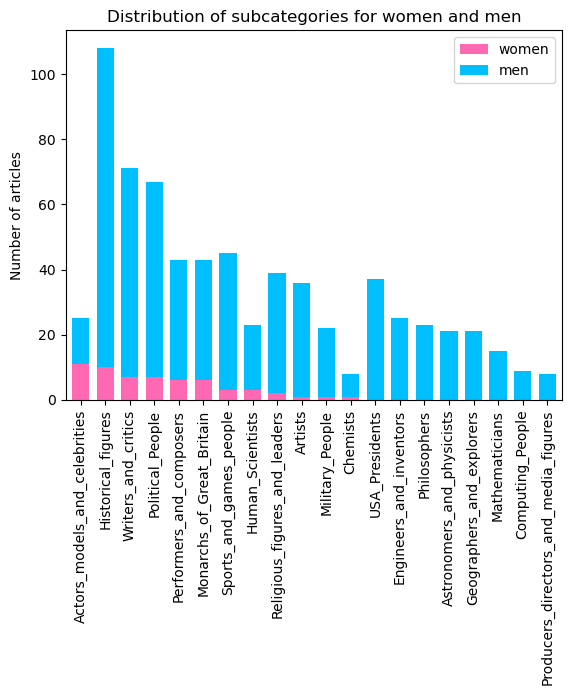

In [102]:
women = womenPeople["category"].str.slice_replace(0, 15, '').value_counts().sort_values(ascending=False)
men = menPeople["category"].str.slice_replace(0, 15, '').value_counts().sort_values(ascending=False)
index = men.keys()

df = pd.DataFrame({'women': women,'men': men}, index=index).sort_values(by = ["women"], ascending = False)
ax = df.plot.bar(stacked = True, color = ['hotpink', 'deepskyblue'], 
                 title = "Distribution of subcategories for women and men",
                         ylabel = 'Number of articles', width = 0.7)

plt.show()

#### MERGE 

By merging `finpaths_women_target` and `finpaths_men_target` on the source article, we can construct a dataframe `comb` that contains rows of all pairs of two target articles (one about a woman, the other about a man) with the same source article.

Example: If five different paths exist from the source article *14th_century* towards the target article *Elizabeth_I_of_England*, and two different paths exist from the same source article towards the target article *John_F._Kennedy*, we would get $5 \times 2 = 10$ number of pairs to compare.

In [154]:
comb_finpaths = finpaths_women_target[["source", "path", "target"]].merge(finpaths_men_target[["source", "path", "target"]], 
                                                        on=['source'], how = "inner",
                                                        suffixes=('_women', '_men'))

In [155]:
comb_finpaths

,source,path_women,target_women,path_men,target_men
0,14th_century,14th_century;England;London;Spanish_Armada;Eng...,Elizabeth_I_of_England,14th_century;Italy;Roman_Catholic_Church;HIV;R...,John_F._Kennedy
1,14th_century,14th_century;England;London;Spanish_Armada;Eng...,Elizabeth_I_of_England,14th_century;Europe;North_America;United_State...,John_F._Kennedy
2,14th_century,14th_century;England;London;Spanish_Armada;Eng...,Elizabeth_I_of_England,14th_century;Europe;<;England;<;Christianity;A...,Henry_David_Thoreau
3,14th_century,14th_century;England;James_I_of_England;Elizab...,Elizabeth_I_of_England,14th_century;Italy;Roman_Catholic_Church;HIV;R...,John_F._Kennedy
4,14th_century,14th_century;England;James_I_of_England;Elizab...,Elizabeth_I_of_England,14th_century;Europe;North_America;United_State...,John_F._Kennedy
...,...,...,...,...,...
469,Ununoctium,Ununoctium;Uranium;World_War_II;The_Holocaust;...,Anne_Frank,Ununoctium;Russia;United_Kingdom;British_monar...,Henry_IV_of_England
470,William_Pitt_the_Younger,William_Pitt_the_Younger;Prime_Minister_of_the...,Miranda_Otto,William_Pitt_the_Younger;British_Empire;Ottoma...,Socrates
471,Windows_2000,Windows_2000;North_America;California;Arnold_S...,Bette_Davis,Windows_2000;Microsoft;United_States;George_Wa...,Ronald_Reagan
472,Windows_2000,Windows_2000;North_America;United_States;Cinem...,Bette_Davis,Windows_2000;Microsoft;United_States;George_Wa...,Ronald_Reagan


#### Getting familiar with the merged data

In [157]:
sources = comb.groupby(comb["source"]).count()
print("The number of distinct sources that go both to women and men are {}".format(len(sources)))
print("The number of paths from all of these sources are {}".format(len(comb)))

The number of distinct sources that go both to women and men are 118
The number of paths from all of these sources are 474


#### Brute-force method to construct the female dataframe

In [35]:
actors = categories[categories["category"] == "subject.People.Actors_models_and_celebrities"]
artist = categories[categories["category"] == "subject.People.Artists"]
astro = categories[categories["category"] == "subject.People.Astronomers_and_physicists"]
chemist = categories[categories["category"] == "subject.People.Chemists"]
comp = categories[categories["category"] == "subject.People.Computing_People"]
eng = categories[categories["category"] == "subject.People.Engineers_and_inventors"]
geo = categories[categories["category"] == "subject.People.Geographers_and_explorers"]
hist = categories[categories["category"] == "subject.People.Historical_figures"]

humsci = categories[categories["category"] == "subject.People.Human_Scientists"]
math = categories[categories["category"] == "subject.People.Mathematicians"]
mil = categories[categories["category"] == "subject.People.Military_People"]
mon = categories[categories["category"] == "subject.People.Monarchs_of_Great_Britain"]
perf = categories[categories["category"] == "subject.People.Performers_and_composers"]
phil = categories[categories["category"] == "subject.People.Philosophers"]
pol = categories[categories["category"] == "subject.People.Political_People"]
prod = categories[categories["category"] == "subject.People.Producers_directors_and_media_figures"] 

rel = categories[categories["category"] == "subject.People.Religious_figures_and_leaders"]
sport = categories[categories["category"] == "subject.People.Sports_and_games_people"]
usa = categories[categories["category"] == "subject.People.USA_Presidents"]
writ = categories[categories["category"] == "subject.People.Writers_and_critics"]